In [1]:
# Ensure TensorFlow uses GPU with dynamic memory growth
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"[GPU setup] {len(gpus)} Physical GPU(s) with memory growth enabled.")
else:
    print("[GPU setup] No GPU found, using CPU.")

# Suppress warnings
import os
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2025-04-20 12:45:54.041700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745153154.220740      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745153154.271466      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[GPU setup] 1 Physical GPU(s) with memory growth enabled.


# Build Pretrained VGG19

In [2]:
def build_vgg19(dropout_rate=0.5):
    base = VGG19(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False

    x = Flatten()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=out)
    return model
    

# Prepare Dataset & Generators

In [3]:
# Paths
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input

data_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
val_dir  = "/kaggle/working/validation"

# Create validation split
for cls in ['REAL', 'FAKE']:
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    files = os.listdir(os.path.join(data_dir, cls))
    _, val_files = train_test_split(files, test_size=0.2, random_state=42)
    for f in val_files:
        src = os.path.join(data_dir, cls, f)
        dst = os.path.join(val_dir, cls, f)
        # Copy across filesystems instead of os.replace
        shutil.copyfile(src, dst)

# Generators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Adversarial Attack Functions (same as before)

In [4]:
@tf.function
def fgsm_attack(model, images, labels, epsilon=0.05):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        loss = tf.keras.losses.BinaryCrossentropy()(labels, preds)
    grad = tape.gradient(loss, images)
    adv = images + epsilon * tf.sign(grad)
    return tf.clip_by_value(adv, -1.0, 1.0)

@tf.function
def pgd_attack(x, y, model, loss_fn,
               epsilon=0.03, alpha=0.007, iters=10):
    x_adv = tf.identity(x)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=False)
            loss = loss_fn(y, pred)
        grad = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grad)
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon) 
        x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
    return x_adv

# Train & Save Baseline Model

In [5]:
baseline_weights = "/kaggle/working/vgg19_baseline.weights.h5"
baseline_model_path = "/kaggle/working/vgg19_baseline_model.h5"

In [6]:
if os.path.exists(baseline_model_path):
    baseline_model = load_model(baseline_model_path)
    print("Loaded existing baseline model.")
else:
    baseline_model = build_vgg19()
    baseline_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
    baseline_model.fit(
        train_gen, epochs=3, validation_data=val_gen)
    baseline_model.save_weights(baseline_weights)
    baseline_model.save(baseline_model_path)
    print("Baseline model trained and saved.")

I0000 00:00:1745153609.481567      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/3


I0000 00:00:1745153619.737121     115 service.cc:148] XLA service 0x7f148000fc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745153619.737958     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745153620.125694     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/3125 ━━━━━━━━━━━━━━━━━━━━ 4:50 93ms/step - accuracy: 0.5781 - loss: 10.5948  

I0000 00:00:1745153628.536946     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 820s 259ms/step - accuracy: 0.8540 - loss: 0.6093 - val_accuracy: 0.9190 - val_loss: 0.2061
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 712s 227ms/step - accuracy: 0.9026 - loss: 0.2380 - val_accuracy: 0.9343 - val_loss: 0.1699
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 699s 223ms/step - accuracy: 0.9110 - loss: 0.2216 - val_accuracy: 0.9434 - val_loss: 0.1438
Baseline model trained and saved.


# Baseline Evaluation

In [7]:
baseline_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [10]:
import numpy as np
import tensorflow as tf

# Number of batches to evaluate (keeps runtime reasonable)
num_batches = 20

# Containers for accuracies
clean_accs = []
fgsm_accs  = []
pgd_accs   = []

# Ensure generator starts from the beginning
test_gen.reset()

# Loss function for PGD
loss_fn = tf.keras.losses.BinaryCrossentropy()

for i in range(num_batches):
    # Fetch a batch
    x_batch, y_batch = next(test_gen)
    x_batch_tensor = tf.convert_to_tensor(x_batch)
    y_batch_tensor = tf.convert_to_tensor(y_batch)
    
    # 1) Clean accuracy
    preds_clean = baseline_model(x_batch, training=False)
    acc_clean = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds_clean), y_batch), tf.float32)).numpy()
    clean_accs.append(acc_clean)

    # 2) FGSM accuracy
    x_adv_fgsm = fgsm_attack(baseline_model, x_batch_tensor, y_batch_tensor)
    preds_fgsm = baseline_model(x_adv_fgsm, training=False)
    acc_fgsm = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds_fgsm), y_batch), tf.float32)).numpy()
    fgsm_accs.append(acc_fgsm)
    

    # 3) PGD accuracy
    x_adv_pgd = pgd_attack(x_batch_tensor, y_batch, baseline_model, loss_fn)
    preds_pgd = baseline_model(x_adv_pgd, training=False)
    acc_pgd = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds_pgd), y_batch), tf.float32)).numpy()
    pgd_accs.append(acc_pgd)

# Print averaged results
print(f"Clean Test Accuracy : {np.mean(clean_accs):.4f}")


Clean Test Accuracy : 0.9406


In [17]:
print(f"FGSM Accuracy    : {np.mean(fgsm_accs):.4f}")
print(f"PGD Accuracy     : {np.mean(pgd_accs):.4f}")

FGSM Accuracy    : 0.1562
PGD Accuracy     : 0.1021


# Generate & Save Perturbed Training Data


 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)


 Model Visualization:


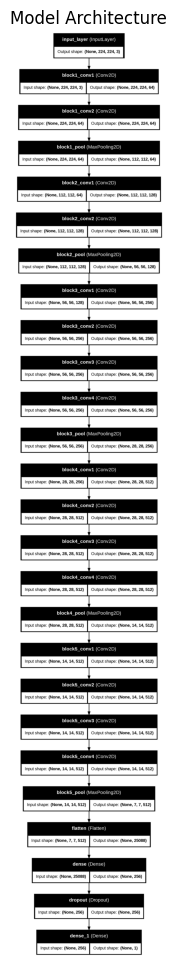


 Total Parameters: 26,447,425
 Trainable Parameters: 6,423,041
 Non-trainable Parameters: 20,024,384

⏱️ Inference Time for 1 batch (32 samples): 0.0268 seconds
 Average Time per Image: 0.0008 seconds


In [18]:
import time
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

# 1. Print Summary
print("\n Model Summary:")
baseline_model.summary()

# 2. Plot the Model Architecture
print("\n Model Visualization:")
plot_model(baseline_model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')

# Display the image in notebook
import PIL.Image
img = PIL.Image.open('model_plot.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.title("Model Architecture")
plt.show()

# 3. Count Parameters
total_params = baseline_model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in baseline_model.trainable_weights])
non_trainable_params = total_params - trainable_params
print(f"\n Total Parameters: {total_params:,}")
print(f" Trainable Parameters: {trainable_params:,}")
print(f" Non-trainable Parameters: {non_trainable_params:,}")

# 5. Inference Time Measurement (on one batch)
x_infer, _ = next(test_gen)
x_infer = tf.convert_to_tensor(x_infer)

start_time = time.time()
_ = baseline_model(x_infer, training=False)
end_time = time.time()

inference_time = end_time - start_time
print(f"\n⏱️ Inference Time for 1 batch ({x_infer.shape[0]} samples): {inference_time:.4f} seconds")
print(f" Average Time per Image: {inference_time / x_infer.shape[0]:.4f} seconds")

In [ ]:


pert_dir = "/kaggle/working/train_perturbed"
for cls in ['REAL','FAKE']:
    os.makedirs(os.path.join(pert_dir,cls), exist_ok=True)

# reload baseline
baseline_model = build_vgg19()
baseline_model.load_weights(baseline_weights)

no_shuffle = ImageDataGenerator(preprocessing_function=preprocess_input)
no_shuffle = no_shuffle.flow_from_directory(
    data_dir, 
    target_size=(224,224), 
    batch_size=32,
    class_mode='binary', 
    shuffle=False
)

loss_fn = tf.keras.losses.BinaryCrossentropy()
num_batches = len(no_shuffle) // 2
for i in tqdm(range(num_batches)):
    xb, yb = next(no_shuffle)
    idx = no_shuffle.index_array[i*32:(i+1)*32]
    paths = [no_shuffle.filepaths[k] for k in idx]
    
    x_adv = fgsm_attack(
        baseline_model,
        tf.convert_to_tensor(xb),
        tf.convert_to_tensor(yb)
    ).numpy()

    for j, pth in enumerate(paths):
        cls_name = 'REAL' if 'REAL' in pth else 'FAKE'
        fn = os.path.basename(pth).replace('.jpg', f'_adv_{i}_{j}.jpg')
        savep = os.path.join(pert_dir, cls_name, fn)
        tf.keras.preprocessing.image.save_img(savep, x_adv[j])

Found 100000 images belonging to 2 classes.


100%|██████████| 1562/1562 [09:07<00:00,  2.85it/s]


# Adversarial Training & Saving

# Robustness Evaluation

In [ ]:
# FGSM adversarial evaluation
x_t, y_t = next(test_gen)
x_t_tensor = tf.convert_to_tensor(x_t)
y_t_tensor = tf.convert_to_tensor(y_t)
x_adv_fgsm = fgsm_attack(adv_model, x_t_tensor, y_t_tensor, epsilon=0.05).numpy()
fgsm_loss, fgsm_acc = adv_model.evaluate(x_adv_fgsm, y_t, verbose=0)
print(f"FGSM Accuracy on Robust Model: {fgsm_acc:.4f}")

# PGD adversarial evaluation
x_p, y_p = next(test_gen)
x_p_tensor = tf.convert_to_tensor(x_p)
y_p_tensor = tf.convert_to_tensor(y_p)

x_adv_pgd = pgd_attack(
    x_p_tensor,
    y_p_tensor,
    adv_model,
    loss_fn,
    epsilon=0.03,
    alpha=0.007,
    iters=10
).numpy()

pgd_loss, pgd_acc = adv_model.evaluate(x_adv_pgd, y_p, verbose=0)
print(f"PGD Accuracy on Robust Model: {pgd_acc:.4f}")